In [2]:
import numpy as np
from functools import partial
from itertools import product

import pennylane as qml
from pennylane import numpy as pnp

from qiskit.providers.aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
import qiskit
    
import jax
from jax import numpy as jnp

import os
import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
rc('font', size=25)
rc('axes', linewidth=3)
rc('text.latex', preamble=r'\usepackage{amsfonts}\usepackage{bm}')

# Circuit for training

In [2]:
def HEA_expect(params, depth, state):
    wires = 2
    qml.BasisStatePreparation(state, wires=range(2))
    for l in range(depth):
        for i in range(2):
            qml.RY(params[2 * wires * l + i], wires=i)
            qml.RZ(params[2 * wires * l + wires + i], wires=i)
        for i in range(0, wires-1, 2):
            qml.CNOT(wires = [i, i+1])
        for i in range(1, wires-1, 2):
            qml.CNOT(wires = [i, i+1])
    return qml.expval(qml.PauliZ(0))

def HEA_circuit(params, depth):
    wires = 2
    for l in range(depth):
        for i in range(2):
            qml.RY(params[2 * wires * l + i], wires=i)
            qml.RZ(params[2 * wires * l + wires + i], wires=i)
        for i in range(0, wires-1, 2):
            qml.CNOT(wires = [i, i+1])
        for i in range(1, wires-1, 2):
            qml.CNOT(wires = [i, i+1])
            
HEA_unitary = qml.matrix(HEA_circuit)

# Tomography on prepared state

In [3]:
def BasisExp(state, ob):
    qml.BasisStatePreparation(state, wires=range(2))
    return qml.expval(ob)

In [3]:
def first_nonzero_index(lst):
    for i, element in enumerate(lst):
        if element != 0:
            return i
    return None  # If no nonzero elements are found

def string2op(s):
    idx = first_nonzero_index(s)
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]
    expr = paulis[s[idx]](idx)
    for i in range(idx+1, len(s)):
        if s[i] != 0:
            expr = expr @ paulis[s[i]](i)
    return expr

def string2op_full(s):
    paulis = [qml.Identity, qml.PauliX, qml.PauliY, qml.PauliZ]
    op = paulis[s[0]](0)
    for i in range(1, len(s)):
        op = op @ paulis[s[i]](i)
    return op

def tomography(func, state, n):
    # nontrivial pauli strings
    pauli_strings = list(product(range(4), repeat=n))[1:]
    # expectation of all paulis
    expvals = np.zeros(4**n - 1)
    for k in range(4**n - 1):
        op = string2op(pauli_strings[k])
        expvals[k] = func(state, op)
    return expvals

def rebuildState_fromTomography(expvals, n):
    # pauli strings
    pauli_strings = list(product(range(4), repeat=n))
    pauli_ops = [string2op_full(s) for s in pauli_strings]
    pauli_ops_matrix = [qml.matrix(x).astype(complex) for x in pauli_ops]
    rho = pauli_ops_matrix[0]
    for k in range(1, 4**n):
        rho += expvals[k] * pauli_ops_matrix[k]
    return rho/2**n

# devices

In [5]:
dev = qml.device("default.qubit", wires=2)
print(dev)
HEA_expect_ideal = qml.QNode(HEA_expect, dev)

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.32.0
Author: Xanadu Inc.
Wires: 2
Shots: None


In [53]:
dev_shot = qml.device('default.qubit', wires=2, shots=500)
print(dev_shot)
HEA_expect_shot = qml.QNode(HEA_expect, dev_shot)

Default qubit PennyLane plugin
Short name: default.qubit
Package: pennylane
Plugin version: 0.32.0
Author: Xanadu Inc.
Wires: 2
Shots: 500


In [61]:
with open('IBMQ_token_usc.txt', 'r') as f:
    TOKEN = f.read().strip()
provider = qiskit.IBMQ.enable_account(TOKEN)

C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_2668\3655029459.py:3: DeprecationWarning: The package qiskit.providers.ibmq is being deprecated. Please see https://ibm.biz/provider_migration_guide to get instructions on how to migrate to qiskit-ibm-provider (https://github.com/Qiskit/qiskit-ibm-provider) and qiskit-ibm-runtime (https://github.com/Qiskit/qiskit-ibm-runtime).
  provider = qiskit.IBMQ.enable_account(TOKEN)
C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_2668\3655029459.py:3: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = qiskit.IBMQ.enable_account(TOKEN)


In [62]:
backend = provider.get_backend('ibm_kyiv')
noise_model = NoiseModel.from_backend(backend)
dev_aer_noise = qml.device("qiskit.aer", wires=2, optimization_level=0, noise_model=noise_model,
                           shots=500)
print(dev_aer_noise)
HEA_expect_noise = qml.QNode(HEA_expect, dev_aer_noise)

NoiseModel:
  Basis gates: ['ecr', 'id', 'reset', 'rz', 'sx', 'x']
  Instructions with noise: ['ecr', 'reset', 'x', 'id', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), ('id', (16,)), ('id', (17,)), ('id', (18,)), ('id', (19,))

# Prepared states fidelity and orthogonality

## ideal

In [ ]:
basisExp_ideal = qml.QNode(BasisExp, dev)

In [18]:
state_list = np.array([[0, 1], [1, 0]])

res = np.ones((2, 4**2))
for i in range(2):
    res[i, 1:] = tomography(basisExp_ideal, state_list[i], 2)
np.save('data/experiment/ideal/statePaulis_n2.npy', res)

## noise simulation

In [7]:
basisExp_noise = qml.QNode(BasisExp, dev_aer_noise)

In [13]:
# state tomography on simulated noisy device
state_list = np.array([[0, 1], [1, 0]])

res = np.ones((20, 2, 4**2))
for t in range(20):
    t0 = time.time()
    for i in range(2):
        state = state_list[i]
        res[t, i, 1:] = tomography(basisExp_noise, state, 2)
    print(f'round={t+1}, time={time.time() - t0} seconds')
np.save('data/experiment/noise/statesPaulis_n2_kyivSimu.npy', res)

round=1, time=19.549792051315308 seconds


In [10]:
# rebuild state
res = np.load('data/experiment/noise/statesPaulis_n2_kyivSimu.npy')
rhos = np.zeros((12, 2, 4, 4), dtype=complex)
for k in range(12):
    for i in range(2):
        rhos[k, i] = rebuildState_fromTomography(res[k, i], 2)
np.save('data/experiment/noise/statesTomo_n2_kyivSimu.npy', rhos)

In [14]:
rhos = np.load('data/experiment/noise/statesTomo_n2_kyivSimu.npy')

purity = np.real(np.einsum('tbij, tbji->tb', rhos, rhos))
print(f'mean and std of purity:{np.mean(purity, axis=0)}, {np.std(purity, axis=0)}')

fids = np.zeros((2, 12))
fids[0] = rhos[:, 0, 1, 1]
fids[1] = rhos[:, 1, 2, 2]
print(f'mean and std of fidelity:{np.mean(fids, axis=1)}, {np.std(fids, axis=1)}')

mean and std of purity:[0.98784967 0.97962033], [0.00805209 0.00777387]
mean and std of fidelity:[0.99108333 0.98625   ], [0.00368462 0.00367707]


C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_24232\1520853049.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  fids[0] = rhos[:, 0, 1, 1]
C:\Users\Bingzhi\AppData\Local\Temp\ipykernel_24232\1520853049.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  fids[1] = rhos[:, 1, 2, 2]


# simulation

In [48]:
# mixed-frozen phase
qubits = 2
depth = 6
state_list = jnp.array([[0, 1], [1, 0]])
ys = jnp.array([-0.3, -3])

stepsize = 0.01
max_iterations = 201

funcs_ideal = [partial(HEA_expect_ideal, depth=depth, state=x) for x in state_list]
funcs_ideal_vag = [jax.jit(jax.value_and_grad(f)) for f in funcs_ideal]

pnp.random.seed(30)
params = pnp.random.uniform(0, 2*np.pi, 2*qubits*depth, requires_grad=True)

eps_hist = np.zeros((max_iterations, 2))
params_hist = np.zeros((max_iterations, 2*qubits*depth))
t0 = time.time()
for t in range(max_iterations):
    ypred1, g1 = funcs_ideal_vag[0](params)
    ypred2, g2 = funcs_ideal_vag[1](params)
    eps1, eps2 = ypred1 - ys[0], ypred2 - ys[1]
    grad_loss = (eps1*g1 + eps2*g2)/len(ys)
    
    eps_hist[t] = [eps1, eps2]
    params_hist[t] = np.array(params)
    
    params -= stepsize*grad_loss
    if t%100 == 0:
        print(f'step={t}, eps={[eps1, eps2]}, time={time.time()-t0: .2f}')

path = f'data/experiment/ideal/D{depth}'
if not os.path.exists(path):
    os.makedirs(path)
np.save(os.path.join(path, f'HEAepshist_n2D{depth}_{ys[0]:.1f}_{ys[1]}.npy'), eps_hist)
np.save(os.path.join(path, f'HEAparamshist_n2D{depth}_{ys[0]:.1f}_{ys[1]}.npy'), params_hist)

step=0, eps=[Array(0.884991, dtype=float32), Array(2.2636137, dtype=float32)], time= 3.04
step=100, eps=[Array(0.11938941, dtype=float32), Array(2.0025306, dtype=float32)], time= 3.13
step=200, eps=[Array(0.01917148, dtype=float32), Array(2.000047, dtype=float32)], time= 3.22


In [51]:
# critical-frozen error phase
qubits = 2
depth = 6
state_list = jnp.array([[0, 1], [1, 0]])
ys = jnp.array([-1, -3])

stepsize = 0.01
max_iterations = 201

funcs_ideal = [partial(HEA_expect_ideal, depth=depth, state=x) for x in state_list]
funcs_ideal_vag = [jax.jit(jax.value_and_grad(f)) for f in funcs_ideal]

pnp.random.seed(30)
params = pnp.random.uniform(0, 2*np.pi, 2*qubits*depth, requires_grad=True)

eps_hist = np.zeros((max_iterations, 2))
params_hist = np.zeros((max_iterations, 2*qubits*depth))
t0 = time.time()
for t in range(max_iterations):
    ypred1, g1 = funcs_ideal_vag[0](params)
    ypred2, g2 = funcs_ideal_vag[1](params)
    eps1, eps2 = ypred1 - ys[0], ypred2 - ys[1]
    grad_loss = (eps1*g1 + eps2*g2)/len(ys)
    
    eps_hist[t] = [eps1, eps2]
    params_hist[t] = np.array(params)
    
    params -= stepsize*grad_loss
    if t%100 == 0:
        print(f'step={t}, eps={[eps1, eps2]}, time={time.time()-t0: .2f}')

path = f'data/experiment/ideal/D{depth}'
if not os.path.exists(path):
    os.makedirs(path)

np.save(os.path.join(path, f'HEAepshist_n2D{depth}_{ys[0]}_{ys[1]}.npy'), eps_hist)
np.save(os.path.join(path, f'HEAparamshist_n2D{depth}_{ys[0]}_{ys[1]}.npy'), params_hist)

step=0, eps=[Array(1.584991, dtype=float32), Array(2.2636137, dtype=float32)], time= 3.53
step=100, eps=[Array(0.31307936, dtype=float32), Array(2.0019867, dtype=float32)], time= 3.62
step=200, eps=[Array(0.16355997, dtype=float32), Array(2.0001755, dtype=float32)], time= 3.70


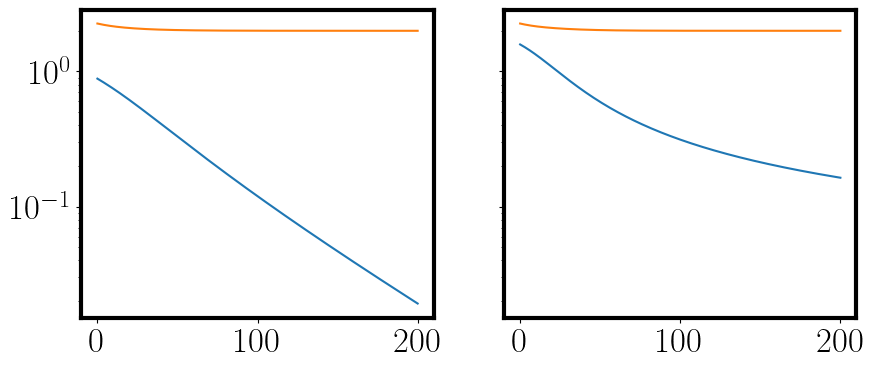

In [52]:
depth = 6
path = f'data/experiment/ideal/D{depth}'

eps1 = np.load(os.path.join(path, f'HEAepshist_n2D{depth}_{-0.3}_{-3.0}.npy'))
eps2 = np.load(os.path.join(path, f'HEAepshist_n2D{depth}_{-1}_{-3}.npy'))

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(eps1)
axs[1].plot(eps2)
axs[0].set_yscale('log')

## ideal device & shot noise

In [ ]:
# mixed-frozen phase
qubits = 2
depth = 6
state_list = [[0, 1], [1, 0]]
O0s = [-0.3, -3.0]

stepsize = 0.01
max_iterations = 201
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

funcs_shot = [partial(HEA_expect_shot, depth=depth, state=x) for x in state_list]

pnp.random.seed(30)
params = pnp.random.uniform(0, 2*np.pi, 2*qubits*depth, requires_grad=True)

def step_and_cost(opt, O0s, objective_fns, *args, grad_fn=None, **kwargs):
    epss = []
    grad_loss = 0.
    for i in range(len(O0s)):
        g, forward = opt.compute_grad(objective_fns[i], args, kwargs, grad_fn=grad_fn)
        epss.append(forward - O0s[i])
        grad_loss += (forward - O0s[i])*g[0]/len(O0s)
    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], epss

path = f'data/experiment/ideal/D{depth}'

eps_hist = np.zeros((max_iterations, 2))
params_hist = np.zeros((max_iterations, 2*qubits*depth))
for t in range(max_iterations):
    new_params, epss = step_and_cost(opt, O0s, funcs_shot, params)
    eps_hist[t] = epss
    params_hist[t] = params
    params = new_params # update parameter
    if t%100 == 0:
        print(t, epss)
np.save(os.path.join(path, f'HEAepshist_n2D{depth}s500_{O0s[0]}_{O0s[1]}.npy'), eps_hist)
np.save(os.path.join(path, f'HEAparamshist_n2D{depth}s500_{O0s[0]}_{O0s[1]}.npy'), params_hist)

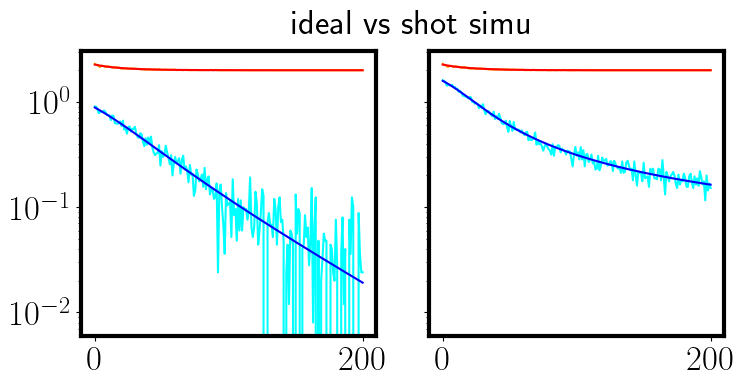

In [92]:
depth = 6
path = f'data/experiment/ideal/D{depth}'

eps_ideal = np.zeros((2, 201, 2))
eps_shot = np.zeros((2, 201, 2))
ys = [(-0.3, -3.0), (-1, -3)]
for i in range(2):
    eps_ideal[i] = np.load(os.path.join(path, f'HEAepshist_n2D{depth}_{ys[i][0]}_{ys[i][1]}.npy'))
    eps_shot[i] = np.load(os.path.join(path, f'HEAepshist_n2D{depth}s500_{ys[i][0]}_{ys[i][1]}.npy'))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
cl = ['cyan', 'b', 'orange', 'r']

for k in range(2):
    axs[0].plot(eps_shot[0, :, k], c=cl[2*k])
    axs[0].plot(eps_ideal[0, :, k], c=cl[2*k+1])
    
    axs[1].plot(eps_shot[1, :, k], c=cl[2*k])
    axs[1].plot(eps_ideal[1, :, k], c=cl[2*k+1])
    
axs[0].set_yscale('log')

fig.text(0.4, 0.95, 'ideal vs shot simu')
plt.tight_layout()

In [ ]:
# noisy hardware simulation
qubits = 2
depth = 6
state_list = [[0, 1], [1, 0]]
O0s = [-0.3, -3.0]

stepsize = 0.01
max_iterations = 101
opt = qml.GradientDescentOptimizer(stepsize=stepsize)

funcs_noise = [partial(HEA_expect_noise, depth=depth, state=x) for x in state_list]

pnp.random.seed(30)
params = pnp.random.uniform(0, 2*np.pi, 2*qubits*depth, requires_grad=True)

def step_and_cost(opt, O0s, objective_fns, *args, grad_fn=None, **kwargs):
    epss = []
    grad_loss = 0.
    for i in range(len(O0s)):
        g, forward = opt.compute_grad(objective_fns[i], args, kwargs, grad_fn=grad_fn)
        epss.append(forward - O0s[i])
        grad_loss += (forward - O0s[i])*g[0]/len(O0s)
    new_args = opt.apply_grad((grad_loss,), args)
    return new_args[0], epss

path = f'data/experiment/noise/D{depth}'
if not os.path.exists(path):
    os.makedirs(path)

eps_hist = np.zeros((max_iterations, 2))
params_hist = np.zeros((max_iterations, 2*qubits*depth))
t0 = time.time()
for t in range(max_iterations):
    new_params, epss = step_and_cost(opt, O0s, funcs_noise, params)
    eps_hist[t] = epss
    params_hist[t] = params
    params = new_params # update parameter
    if t%1 == 0:
        print(f'step={t}, eps={epss}, time={time.time() - t0} seconds')
np.save(os.path.join(path, f'HEAepshist_n2D{depth}s500_{O0s[0]}_{O0s[1]}_kyivSimu.npy'), eps_hist)
np.save(os.path.join(path, f'HEAparamshist_n2D{depth}s500_{O0s[0]}_{O0s[1]}_kyivSimu.npy'), params_hist)

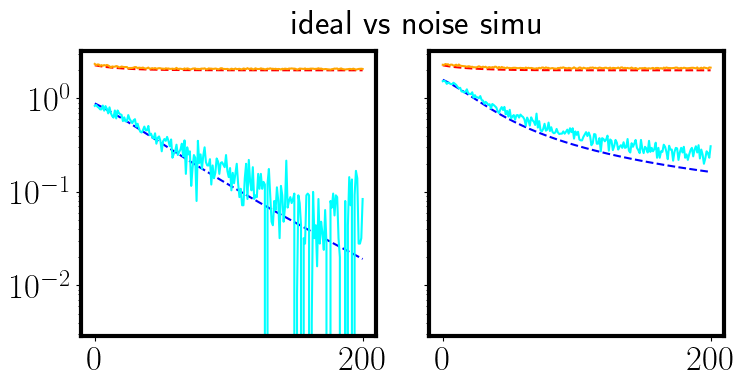

In [29]:
depth = 6
path1 = f'data/experiment/ideal/D{depth}'
path2 = f'data/experiment/noise/D{depth}'

eps_ideal = np.zeros((2, 201, 2))
eps_noiseSimu = np.zeros((2, 201, 2))
ys = [(-0.3, -3.0), (-1, -3)]
for i in range(2):
    eps_ideal[i] = np.load(os.path.join(path1, f'HEAepshist_n2D{depth}_{ys[i][0]}_{ys[i][1]}.npy'))
    eps_noiseSimu[i] = np.load(os.path.join(path2, f'HEAepshist_n2D{depth}s500_{ys[i][0]}_{ys[i][1]}_kyivSimu.npy'))

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
cl = ['cyan', 'b', 'orange', 'r']

for k in range(2):
    axs[0].plot(eps_ideal[0, :, k], '--', c=cl[2*k+1])
    axs[0].plot(eps_noiseSimu[0, :, k], c=cl[2*k])

    axs[1].plot(eps_ideal[1, :, k], '--', c=cl[2*k+1])
    axs[1].plot(eps_noiseSimu[1, :, k], c=cl[2*k])

axs[0].set_yscale('log')

fig.text(0.4, 0.95, 'ideal vs noise simu')
plt.tight_layout()

## critical-frozen-error phase

In [ ]:
# ideal
qubits = 2
depth = 6
state_list = jnp.array([[0, 1], [1, 0]])
O0s = jnp.array([-1, -3])

stepsize = 0.01
max_iterations = 201

funcs_ideal = [partial(HEA_expect_ideal, depth=depth, state=x) for x in state_list]
funcs_ideal_vag = [jax.jit(jax.value_and_grad(f)) for f in funcs_ideal]

pnp.random.seed(30)
params = pnp.random.uniform(0, 2*np.pi, 2*qubits*depth, requires_grad=True)

eps_hist = np.zeros((max_iterations, 2))
params_hist = np.zeros((max_iterations, 2*qubits*depth))
t0 = time.time()
for t in range(max_iterations):
    ypred1, g1 = funcs_ideal_vag[0](params)
    ypred2, g2 = funcs_ideal_vag[1](params)
    eps1, eps2 = ypred1 - O0s[0], ypred2 - O0s[1]
    grad_loss = (eps1*g1 + eps2*g2)/len(O0s)
    
    eps_hist[t] = [eps1, eps2]
    params_hist[t] = np.array(params)
    
    params -= stepsize*grad_loss
    if t%20 == 0:
        print(f'step={t}, eps={[eps1, eps2]}, time={time.time()-t0: .2f}')

path = 'data/experiment/ideal'
if not os.path.exists(path):
    os.makedirs(path)
O0s = np.array(O0s)
np.save(os.path.join(path, f'HEAepshist_n2D{depth}_{O0s[0]:.1f}_{O0s[1]}.npy'), eps_hist)
np.save(os.path.join(path, f'HEAparamshist_n2D{depth}_{O0s[0]:.1f}_{O0s[1]}.npy'), params_hist)

# Experiment

## Tomography

In [4]:
rhos01 = np.load('data/experiment/noise/01rhos_n2_kyiv.npy')
rhos10 = np.load('data/experiment/noise/10rhos_n2_kyiv.npy')

purity1 = np.real(np.einsum('tij, tji->t', rhos01, rhos01))
print(f'mean and std of purity for |01>:{np.mean(purity1)}, {np.std(purity1)}')
purity2 = np.real(np.einsum('tij, tji->t', rhos10, rhos10))
print(f'mean and std of purity for |10>:{np.mean(purity2)}, {np.std(purity2)}')

fids1 = rhos01[:, 1, 1]
print(f'mean and std of fidelity for |01>:{np.mean(fids1)}, {np.std(fids1)}')
fids2 = rhos10[:, 2, 2]
print(f'mean and std of fidelity for |10>:{np.mean(fids2)}, {np.std(fids2)}')

mean and std of purity for |01>:0.9975736666666668, 0.004455690730839453
mean and std of purity for |10>:0.9935116666666666, 0.004728324145214929
mean and std of fidelity for |01>:(0.9958333333333332+0j), 0.0017716909687891102
mean and std of fidelity for |10>:(0.99375+0j), 0.0019632031648982927


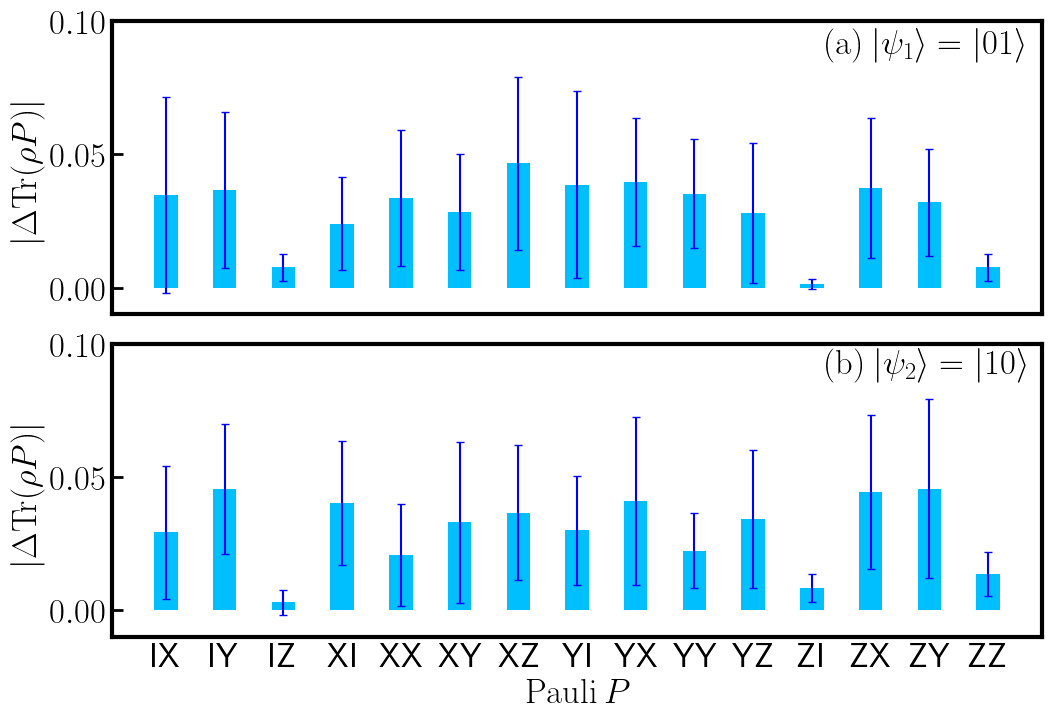

In [2]:
ps_01 = np.load('data/experiment/noise/01Paulis_n2_kyiv.npy')
ps_10 = np.load('data/experiment/noise/10Paulis_n2_kyiv.npy')
ps_ideal = np.load('data/experiment/ideal/statePaulis_n2.npy')

pauli_dict = ['I', 'X', 'Y', 'Z']
pauli_labels = [pauli_dict[s[0]]+pauli_dict[s[1]] for s in product(range(4), repeat=2)]

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
width = 0.4
d1 = np.abs(ps_01-ps_ideal[0])
axs[0].bar(np.arange(15), np.mean(d1, axis=0)[1:], color='deepskyblue', width=width)
axs[0].errorbar(np.arange(15), np.mean(d1, axis=0)[1:], yerr=np.std(d1, axis=0)[1:], color='b', 
    markersize=0, fmt='o', capsize=3)
axs[0].set_xticks(np.arange(15))
axs[0].set_xticklabels([])

d2 = np.abs(ps_10-ps_ideal[1])
axs[1].bar(np.arange(15), np.mean(d2, axis=0)[1:], color='deepskyblue', width=width)
axs[1].errorbar(np.arange(15), np.mean(d2, axis=0)[1:], yerr=np.std(d2, axis=0)[1:], 
    color='b', markersize=0, fmt='o', capsize=3)
axs[1].set_xticks(np.arange(15), pauli_labels[1:])
axs[1].set_xlabel(r'${\rm Pauli}\:P$')

for i in range(2):
    axs[i].set_ylabel(r'$|\Delta {\rm Tr}(\rho P)|$')
    axs[i].set_ylim(-0.01, 0.1)
    axs[i].tick_params(axis='x', length=0)
    axs[i].tick_params(axis='y', length=8, width=2, direction='in')
plt.subplots_adjust(hspace=0.1)

fig.text(0.72, 0.84, r'$\rm (a)\: |\psi_1\rangle=|01\rangle$')
fig.text(0.72, 0.44, r'$\rm (b)\: |\psi_2\rangle=|10\rangle$')

plt.savefig('figures/states_tomo.pdf', bbox_inches='tight')
plt.show()
plt.close()

## training

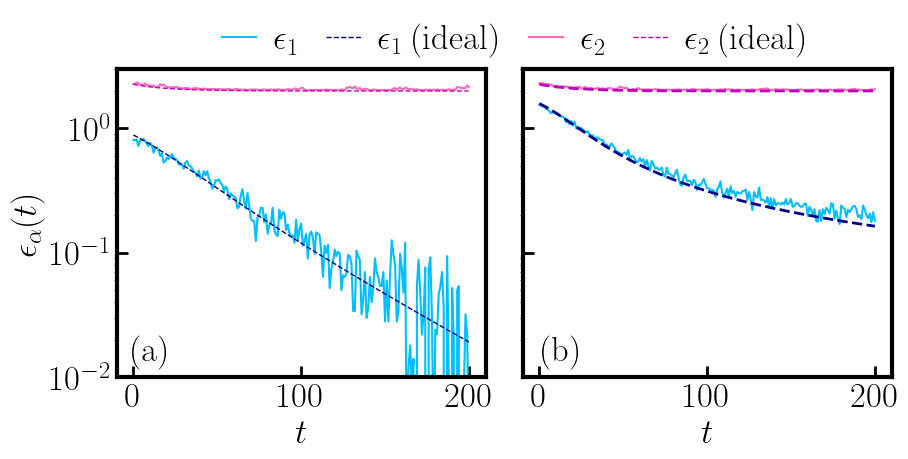

In [4]:
eps_hist1 = np.load('data/experiment/noise/D6/HEAepshist_n2D6s500_-0.3_-3.0_kyiv.npy')
eps_hist2 = np.load('data/experiment/noise/D6/HEAepshist_n2D6s500_-1_-3_kyiv.npy')

eps_ideal1 = np.load('data/experiment/ideal/D6/HEAepshist_n2D6_-0.3_-3.0.npy')
eps_ideal2 = np.load('data/experiment/ideal/D6/HEAepshist_n2D6_-1_-3.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
cl1 = ['darkblue', 'm']
cl2 = ['deepskyblue', 'hotpink']
for i in range(2):
    axs[0].plot(np.mean(eps_hist1[:, :, i], axis=0), c=cl2[i], label=fr'$\epsilon_{i+1}$')
    axs[0].plot(eps_ideal1[:, i], '--', lw=1, c=cl1[i], label=fr'$\epsilon_{i+1}$' + r'$\rm\:(ideal)$')
    
    axs[1].plot(np.mean(eps_hist2[:, :, i], axis=0), c=cl2[i])
    axs[1].plot(eps_ideal2[:, i], '--', lw=2, c=cl1[i])
    
    axs[i].set_xlabel(r'$t$')
    axs[i].tick_params(length=8, width=2, direction='in')
axs[0].legend(ncol=4, handlelength=1, columnspacing=0.8, handletextpad=0.5, loc='upper left', 
    bbox_to_anchor=(0.2, 1.25), framealpha=0)
axs[0].set_yscale('log')
axs[0].set_ylim(1e-2, 3)
axs[0].set_xlim(-10, 210)
axs[0].set_ylabel(r'$\epsilon_\alpha (t)$')

fig.text(0.14, 0.15, r'$\rm (a)$')
fig.text(0.55, 0.15, r'$\rm (b)$')

plt.subplots_adjust(wspace=0.1)

plt.savefig('figures/experiment.pdf', bbox_inches='tight')
plt.show()
plt.close()

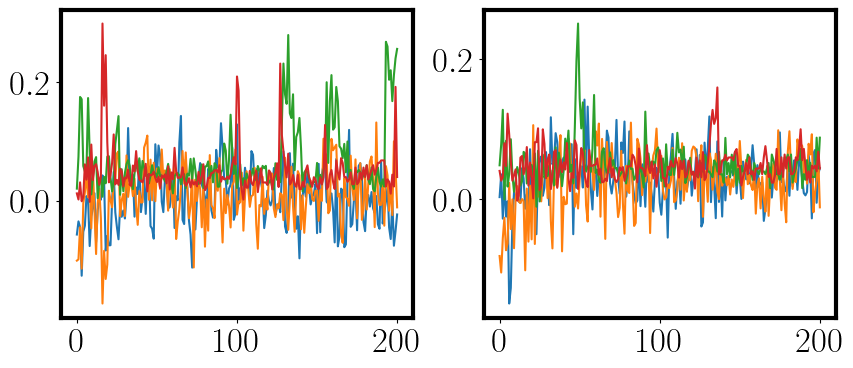

In [39]:
eps_hist1 = np.load('data/experiment/noise/D6/HEAepshist_n2D6s500_-0.3_-3.0_kyiv.npy')
eps_hist2 = np.load('data/experiment/noise/D6/HEAepshist_n2D6s500_-1_-3_kyiv.npy')

eps_ideal1 = np.load('data/experiment/ideal/D6/HEAepshist_n2D6_-0.3_-3.0.npy')
eps_ideal2 = np.load('data/experiment/ideal/D6/HEAepshist_n2D6_-1_-3.npy')

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True)
for i in range(2):
    ds1 = eps_hist1[:, :, i] - eps_ideal1[:, i]
    axs[0].plot(ds1.T)
    ds2 = eps_hist2[:, :, i] - eps_ideal2[:, i]
    axs[1].plot(ds2.T)